# Part 3 System Level Integration Using PYNQ Flow

Instead of using the AXI4 interface, we used the AXI4-Stream style for the interface design of the Sobel accelerator. Compared to AXI4, AXI4-Stream is more suitable for high-speed data stream transmission in video, communication and signal processing scenarios. It removes the limitation of address entries and transmission length in AXI protocol, allowing unlimited data burst transmission.

<img src="./image/AXI-stream_trans_type.png" alt="AXI-stream_trans_type.png" style="zoom:60%;" />

Afterwards we will introduce two axes of the PYNQ development process, direct calls and Driver creation. In the former we will show a direct call like DSP_FIR filter, and in the latter we will build a user-friendly API by creating a Driver.

## 1. Data Transfer

### 1.1 Data Type Chosen On AXI-Stream Interface 

 In the `sobel` function, we specify the interface as AXI4-Stream format by `hls::stream<trans_pkt>& src` and `hls::stream<trans_pkt>& dst`, and PIXEL corresponds to the format of each pixel. The final two streams `src` and `dst` obtained correspond to the input image and the output image respectively, which makes the `sobel` function have a streaming input-output interface.。

Inside the `sobel` function, we extract pixels from the input stream `src` for computation, and fill the result just after computation back into the output stream `dst`. This is another important reason for using a line buffer in our design, which makes the access to the pixel data continuous and makes it appropriate to read and write the data with AXI-Stream.

The implementation is also relatively simple for reading and writing stream data. We can look at the steps in order of their sequence within the loop. First, we have extracted a pixel to be processed from the input stream by `data_p = src.read() ` and filled it into the line buffer for subsequent operations. After that, we have gotten the result of one pixel by `_sobel = sobel3x3_kernel(WindowBuffer)` calculation. At this point we don't have to wait for the whole image to be computed, we can immediately write this pixel to the output stream `dst` via `dst.write(data_p)`. 

### 1.2 AXI-DMA Control Over AXI-Stream Interface

With the use of the AXI-Stream interface, we will also have some changes in the integration of the system. In FIR aaccelerated IP, we connect the IP directly to the HP port of the PS, making it possible to get data from the IP to the PS side through the AXI4 bus, a very intuitive connection that we have already touched (figure below).

<img src="./image/AXIIP_PS.png" alt="AXIIP_PS.png" style="zoom:40%;" />

In this case, the data in memory is not directly transferred to the IP through the AXI bus. Because the data is in the style of Memory Map, the concept of target address in the storage space is involved in the transfer. The AXI-Stream is centered on the data stream, which does not exist and does not require the concept of address, making it impossible to connect the IP of the AXI-Stream interface directly to the AXI bus.

At this point, we need the help of the Direct Memory Access module (DMA), whose function is to help us convert the data in memory into stream format and then transfer the data in stream format to the IP's AXI-Stream interface, whose basic structure in the system can be represented by the following diagram.

<img src="./image/DMA.png" alt="DMA.png" style="zoom:40%;" />

There are three interfaces on DMA: AXI-Full, AXI-Stream and AXI-Lite. AXI-Full is used to read and write data from memory, AXI-Stream is used to read and write data to IP, and AXI-Lite is used for PS control of DMA. Therefore, all three interfaces are used in the DMA usage. Let's take the data handling of this Sobel case as an example to analyze the basic flow in DMA data handling.

1. The PS configures and controls the DMA through the AXI-Lite interface to determine the starting address and length of the image data to be transferred in memory
2. After receiving the control command from the PS, the DMA will read a batch of pixel data from the memory through the AXI-Full interface
3. The DMA converts the pixel data from memory mapping style to stream style and sends it to the Sobel IP receiving channel src
4. Sobel IP starts the calculation and sends the result to DMA via AXI-Stream's send channel dst when it is available for output
5. After the DMA receives the calculation result, it converts the data from stream style to memory mapped style and writes it to memory at the location specified by the configuration in step 1

As we can see, the main function of DMA is data handling, which converts data in memory to stream format and sends it to the IP. In fact, many high-performance IPs require input and output in stream format, so DMA will also appear very frequently in high-performance designs.

## 2. Three Different Sobel Implementation to Extract Image Edges

### 2.1 Using Sobel in OpenCV-Python

#### 2.1.1 Load the Original Grayscale Image

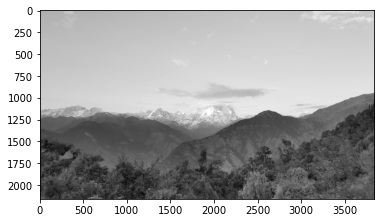

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import time
import copy
gray = cv.imread("./image/4k.jpg", cv.IMREAD_GRAYSCALE)
plt.imshow(gray, cmap="gray")

#### 2.1.2 Using `cv.Sobel()`

Time cost with software：0.5069916248321533s


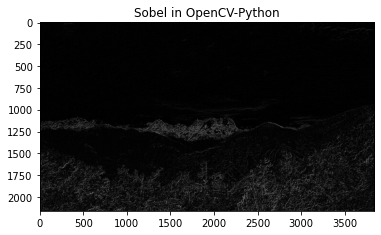

In [2]:
# Apply Sobel filter to get the gradients in X and Y direction
# The Sobel operator calculates the gradient of the image intensity at each pixel

start_time_python = time.time()

Gx = cv.Sobel(gray, cv.CV_16U, 1, 0, ksize=3)  # Gradient in X direction
Gy = cv.Sobel(gray, cv.CV_16U, 0, 1, ksize=3)  # Gradient in Y direction

# Compute the gradient magnitude
G = np.sqrt(Gx**2 + Gy**2)
# Convert to 8-bit image for display
G_python = G.astype(np.uint8)

end_time_python = time.time()

time_python = end_time_python - start_time_python

print("Time cost with software：{}s".format(time_python))

plt.title("Sobel in OpenCV-Python")
plt.imshow(G_python, cmap="gray")

### 2.2 Using Hand-Coded Sobel Hardware Accelerated Kernel

#### 2.2.1 Loading Overlay

We deploy the hardware design to the board, allocate the memory according to the image size, and copy the image to the corresponding location.

The `Overlay` module encapsulates the interface for the ARM CPU to interact with the PL part of the FPGA.

- We can load the hardware design we just generated onto the PL with the simple `Overlay()` method
- With the `overlay.sobel_accel_0` statement, we can interact with the IP in the form of an accessed Python object

In [3]:
from pynq import Overlay, allocate

overlay = Overlay("./sobel_opt.bit")
sobel = overlay.sobel_0

# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

#### 2.2.2 Writing parameters

When writing values on the IP, we can write directly at the corresponding location according to the IP Driver Source Code given by HLS.
```python
sobel.write(0x10, rows)
sobel.write(0x18, cols)
```
However, thanks to the `Sobel.hwh` file provided, the `sobel` object already contains the Register Map and exposes it, so we can directly print to see the information of each register, and we can use `.address` to get the relevant address, like using `sobel.register_map.rows.address` to get `0x10`.


In [4]:
sobel.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}


We can also interact with it directly in the Register Map, without having to manually enter the corresponding address.

In [5]:
sobel.register_map.rows = rows
sobel.register_map.cols = cols

#### 2.2.3 Starting IP

We extract the DMA object from the IP.

Sobel IP uses the AXI Stream interface format.

- We need to call the DMA to read the input buffer and send the data to the AXI Stream Master

- After that, the DMA should write the result back to the output buffer from the AXI Stream Slave

- The `wait` statement ensures that the DMA processing operation is completed

In [6]:
dma = overlay.axi_dma_0

Time cost with handcoded IP：0.0575566291809082s


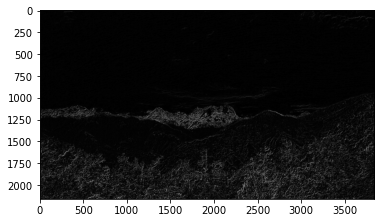

In [7]:
import time

sobel.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

time_handcoded = end_time - start_time
print("Time cost with handcoded IP：{}s".format(time_handcoded))
# G_handcoded = copy.deepcopy(output_buffer.reshape(rows, cols))
G_handcoded = output_buffer.reshape(rows, cols)
plt.imshow(G_handcoded,cmap='gray')


#### 2.2.4 Create a Driver for the IP

Our next step involves creating a user-friendly API to facilitate the creation of a driver for a specific IP.

- Expose a single `sobel3x3` function to call the accelerator

- Inherit pynq's `DeafaultIP`


In [8]:
from pynq import DefaultIP

class SobelDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:sobel:1.0']

    def sobel3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res


#### 2.2.5 Reload the overlay to apply the changes

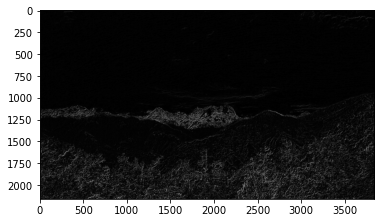

In [9]:
overlay = Overlay("./sobel_opt.bit")
dma = overlay.axi_dma_0
sobel = overlay.sobel_0

res = sobel.sobel3x3(input_buffer, output_buffer, rows, cols)

plt.imshow(res,cmap='gray')

### 2.3 Using Sobel in Vitis Vision Library

####  2.3.1 Loading Overlay

The Overlay module encapsulates the interface for the ARM CPU to interact with the PL part of the FPGA.

- We can load the hardware design we just generated onto the PL with the simple `Overlay()` method
- With the `overlay.sobel_accel_0` statement, we can interact with the IP in the form of an accessed Python object

In [10]:
from pynq import Overlay
overlay = Overlay("./sobel_xf_kv260.bit")
sobel = overlay.sobel_accel_0

In [11]:
sobel.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  img_inp_1 = Register(img_inp=write-only),
  img_inp_2 = Register(img_inp=write-only),
  img_out1_1 = Register(img_out1=write-only),
  img_out1_2 = Register(img_out1=write-only),
  img_out2_1 = Register(img_out2=write-only),
  img_out2_2 = Register(img_out2=write-only),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

#### 2.3.2 Allocating memory for IP use

The `pynq.allocate` function is used to allocate memory space that can be used by the IP in PL.
- Before the IP in PL can access DRAM, some memory must be reserved for it to be used by the IP. Allocation size and address
- We allocate memory for the input, output and weight sections separately, with data type uint8
- `pynq.allocate` will allocate physically contiguous memory and return a `pynq.Buffer` indicating that a buffer has been allocated

In [12]:
from pynq import allocate
import numpy as np

rows, cols = gray.shape
pixel_size = rows*cols
input_buffer = allocate(shape=(pixel_size,), dtype='u1')
output_buffer_1 = allocate(shape=(pixel_size,), dtype='u1')
output_buffer_2 = allocate(shape=(pixel_size,), dtype='u1')



img_reshape = gray.reshape(pixel_size,)
np.copyto(input_buffer, img_reshape)

#### 2.3.3 Configuring IP
Since the `.hwh` file has been provided, the `sobel_accel` object already includes the Register Map and exposes it. We can directly print and inspect information about each register.

In [13]:
sobel.register_map.rows = rows
sobel.register_map.cols = cols
sobel.write(sobel.register_map.img_inp_1.address, input_buffer.physical_address)
sobel.write(sobel.register_map.img_out1_1.address, output_buffer_1.physical_address)
sobel.write(sobel.register_map.img_out2_1.address, output_buffer_2.physical_address)

#### 2.3.4 Starting IP

The control signal is located at address 0x00, which we can write and read to control whether the IP start and listen is completed.

In [16]:
import time

sobel.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = sobel.read(0x00)
    if reg != 1:
        break
end_time = time.time()
time_visionLib = end_time - start_time

print("Time cost with vison library IP：{}s".format(end_time - start_time))

KeyboardInterrupt: 

The results have been written to the `output_buffer`, which we can view.

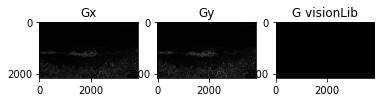

In [17]:
G_visionLib = output_buffer_1.reshape(rows, cols) + output_buffer_2.reshape(rows, cols)
plt.subplot(131)
plt.title("Gx")
plt.imshow(G_python, cmap="gray")
plt.subplot(132)
plt.title("Gy")
plt.imshow(G_handcoded, cmap="gray")
plt.subplot(133)
plt.title("G visionLib")
plt.imshow(G_visionLib, cmap="gray")

## 3. Performance Comparison Between Python-OpenCV, Hand-Coded HLS Kernel and Vitis Vision Library Sobel

We can simply load the hand-Coded and vision library version of Sobel to compare the performance.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

# prepare data
x_data = ['Sobel OpenCV-Python','Sobel Handwritten', 'Sobel Vision Library']
y_data = [time_python, time_handcoded, time_visionLib]


for i in range(len(x_data)):
    plt.bar(x_data[i], y_data[i])

for a,b in zip(x_data,y_data):   
    plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=11);
    
plt.title("Time used of different types")
plt.xlabel("Type")
plt.ylabel("Time(s)")

plt.show()

NameError: name 'time_visionLib' is not defined



### Staged Tasks

1. Configure the HLS Stream interface for matrix multiplication calculations using the cache and place it on the PYNQ board to run successfully.

--------------

<p align="center">Copyright&copy; 2024 Advanced Micro Devices</p>
